# BERT (Encoder-only-model)

- Token classification 
    NER
- Sequence classification
    Sentiment Classification
    Relation Extraction (RE)
- Text Clustering (BERTopic)
    Embedding model
    Clustering model
    使用Representation方法去微調主題表示


In [1]:


import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# 載入資料集
fake_df = pd.read_csv('./raw_data/fake.csv')
true_df = pd.read_csv('./raw_data/true.csv')

# 合併 title 和 text 成新的 text 欄位
fake_df['text'] = fake_df['title'].astype(str) + " " + fake_df['text'].astype(str)
true_df['text'] = true_df['title'].astype(str) + " " + true_df['text'].astype(str)

# 加上 label 欄位
fake_df['label'] = 1
true_df['label'] = 0

# 取前 10000 筆
dataNum = 1000
news_data = pd.concat([fake_df.iloc[:dataNum], true_df.iloc[:dataNum]], ignore_index=True)

# 移除空值並只保留 text 和 label 欄位
news_data = news_data[news_data['text'].notna()].reset_index(drop=True)
news_data = news_data[['text', 'label']]

# 檢查各類別數量
print(news_data['label'].value_counts())
print(news_data.head(1))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


label
1    1000
0    1000
Name: count, dtype: int64
                                                text  label
0   Donald Trump Sends Out Embarrassing New Year’...      1


In [2]:
# 推特資料處理(為了嘗試解決 加入TF-IDF過擬合&embed過強 可能是因為文本特徵太明顯的問題)    
tweet_df = pd.read_csv('./raw_data/Truth_Seeker_Model_Dataset_unindex.csv', encoding='ISO-8859-1')
tweet_data = tweet_df[['BinaryNumTarget', 'tweet', '5_label_majority_answer']].copy()

# 清理
tweet_data = tweet_data.dropna()
tweet_data = tweet_data[~tweet_data['tweet'].str.contains('#REF!', na=False)]
valid_labels = ['Agree', 'Mostly Agree']
tweet_data = tweet_data[tweet_data['5_label_majority_answer'].isin(valid_labels)]

# 移除 5_label_majority_answer 欄位，並重新命名欄位
tweet_data = tweet_data.rename(columns={'BinaryNumTarget': 'label', 'tweet': 'text'})
tweet_data = tweet_data[['text', 'label']]

tweet_data_num = 1000  # 取n筆
tweet_data = tweet_data.groupby('label').apply(
    lambda x: x.sample(n=min(len(x), tweet_data_num), random_state=42)
).reset_index(drop=True)


print(tweet_data['label'].value_counts())
print(tweet_data.head(10))

label
0    1000
1    1000
Name: count, dtype: int64
                                                text  label
0  @judyannaggie @RichardGrenell That's why the b...      0
1  @drmeowza I  so sorry that you are I'll. I wis...      0
2  @charlie_savage You do realize he said AntiFa ...      0
3  @AshleeFulcher1 @JennieNguyenLuv So you agree ...      0
4    Bruno Mars is Michael Jackson secret son.......      0
5  The CDC admitted that it is mixing antibody an...      0
6  @mutxtiger @MacFarlaneNews @JWilson420yes He s...      0
7  @matanevenoff @SpeakerPelosi Why this is insan...      0
8  KAMLA HARRIS praises the Marxists BlackLivesMa...      0
9  @blackbartohio In 38 days Pelosi and Schiff \n...      0


C:\Users\USER\AppData\Local\Temp\ipykernel_24932\2631504573.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tweet_data = tweet_data.groupby('label').apply(


In [3]:
# 合併兩份不同來源資料集
data = pd.concat([news_data, tweet_data], ignore_index=True)

## 需要做文本預處理嗎?

目的:
- 建立分類器來預測真假新聞 -> (TF-IDF + 分類模型需要乾淨的資料，有幫助)
- 分析NER 結果與語意分佈 -> (會破壞語意)
- 建立主題模型來探索語意主題（BERTopic -> (會破壞語意)

In [4]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

data['tokens'] = data['text'].astype(str).apply(preprocess)
data['clean_text'] = data['tokens'].apply(lambda x: ' '.join(x))



## NER 預測新聞真假

In [6]:
from matplotlib.font_manager import fontManager
import matplotlib.pyplot as plt

fontManager.addfont('./public/TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

In [7]:
from sklearn.cluster import KMeans
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

# 載入模型與 tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# 建立 NER 結果列表
ner_rows = []

# 分切字串
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# 針對每篇文章跑 NER（可用 tqdm 顯示進度條）
for idx, text in tqdm(data['text'].astype(str).items()):
    try:
        chunks = split_text(text)
        all_ents = []
        for chunk in chunks:
            all_ents.extend(ner_pipeline(chunk))  # 對每段跑 NER
        for ent in all_ents:
            ner_rows.append({
                "index": idx,
                "entity": ent['entity_group'],  # e.g., PER, LOC
                "word": ent['word'],
                "score": ent['score']
            })
    except Exception as e:
        print(f"Error at idx {idx}: {e}")

# 建立 DataFrame
ner_df = pd.DataFrame(ner_rows)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
4000it [14:22,  4.64it/s]


In [8]:
ner_df.head(10)


,index,entity,word,score
0,0,PER,Donald Trump,0.998793
1,0,PER,Donald Trump,0.998276
2,0,MISC,Americans,0.998982
3,0,ORG,Fake News Media,0.919783
4,0,PER,Angry Pants,0.970617
5,0,LOC,America,0.999643
6,0,LOC,Country,0.439499
7,0,ORG,F,0.988801
8,0,ORG,##ake News Media,0.961964
9,0,LOC,America,0.999575


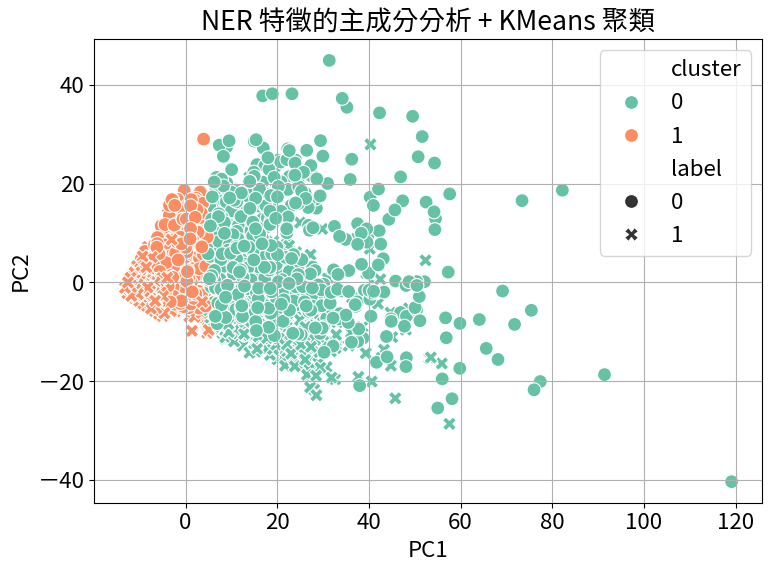

In [9]:
# 整合 label
merged_df = ner_df.merge(data[['label']], left_on='index', right_index=True)

# 聚合所有 entity 類型的出現次數
entity_counts_all = (
    merged_df.groupby(['index', 'entity'])
    .size()
    .unstack(fill_value=0)  # 得到每篇文章各類實體數
    .reset_index()
)

# 合併 label
entity_counts_all = entity_counts_all.merge(data[['label']], left_on='index', right_index=True)

# 建模欄位選擇：所有實體類別欄位（排除 index, label）
feature_cols = [col for col in entity_counts_all.columns if col not in ['index', 'label']]
kmeans_fit_pred_data = entity_counts_all[feature_cols]

# 做 KMeans 聚類
from sklearn.cluster import KMeans
import seaborn as sns

kmeans = KMeans(n_clusters=2, random_state=42)
entity_counts_all['cluster'] = kmeans.fit_predict(kmeans_fit_pred_data)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans_fit_pred_data)
entity_counts_all['PC1'] = X_pca[:, 0]
entity_counts_all['PC2'] = X_pca[:, 1]
# 視覺化聚類結果
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=entity_counts_all,
    x='PC1', y='PC2', hue='cluster', style='label',
    palette='Set2', s=100
)

plt.title('NER 特徵的主成分分析 + KMeans 聚類')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 嘗試用 NER 提取出的'人名'、'組織'、'地名數量'作為詞彙特徵，再餵給 TF-IDF + 模型來預測這篇新聞是真/假

In [10]:
from sklearn.ensemble import RandomForestClassifier

# 聚合 ner_df 結果為特徵表（以 index = 文章編號為 key）
entity_counts = ner_df.groupby(['index', 'entity']).size().unstack(fill_value=0)

# 合併回原資料集
data_with_ner = data.copy()
data_with_ner = data_with_ner.join(entity_counts, how='left').fillna(0)

# 建立特徵：人名、組織、地名數量
ner_pred_X = data_with_ner[['PER', 'ORG', 'LOC']]
ner_pred_y = data_with_ner['label']

# 建模
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(ner_pred_X, ner_pred_y, test_size=0.2, random_state=42)
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)

# Logistic Regression 結果
print("=== LogisticRegression 分類結果 ===")
print(classification_report(y_test, lr_pred))

# Random Forest 結果
print("=== RandomForestClassifier 分類結果 ===")
print(classification_report(y_test, rf_y_pred))

=== LogisticRegression 分類結果 ===
              precision    recall  f1-score   support

           0       0.62      0.49      0.55       407
           1       0.57      0.69      0.62       393

    accuracy                           0.59       800
   macro avg       0.59      0.59      0.59       800
weighted avg       0.59      0.59      0.58       800

=== RandomForestClassifier 分類結果 ===
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       407
           1       0.65      0.72      0.68       393

    accuracy                           0.67       800
   macro avg       0.67      0.67      0.67       800
weighted avg       0.67      0.67      0.67       800



### NER提取特徵預測結果尚可
小結:
預測真新聞:  LR      RF
precision   0.71    0.75
recall      0.62    0.74
f1          0.66    0.74

預測假新聞:
precision   0.66    0.74
recall      0.74    0.75
f1          0.70    0.74

NER 特徵對真假新聞辨識有一定程度作用，且用RandomForest的結果較優

## 使用情緒分析辨識真假新聞

In [11]:
# 載入情緒分析模型(微調後的BERT)
model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# 因為這個語言也是BERT = 效果仰賴'自然語言語序與上下文' = 使用data['text']即可

# 切割文字 每段不超過 512 字
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# 整合段落的情緒分數
def analyze_long_text(text):
    try:
        chunks = split_text(text)
        results = model(chunks)

        # 統計情緒
        pos_scores = [r['score'] for r in results if r['label'] == 'POSITIVE']
        neg_scores = [r['score'] for r in results if r['label'] == 'NEGATIVE']

        # 平均分數
        avg_pos = sum(pos_scores) / len(pos_scores) if pos_scores else 0
        avg_neg = sum(neg_scores) / len(neg_scores) if neg_scores else 0

        # 決定總體情續
        if avg_pos > avg_neg:
            return pd.Series(['POSITIVE', avg_pos])
        elif avg_neg > avg_pos:
            return pd.Series(['NEGATIVE', avg_neg])
        else:
            return pd.Series(['NEUTRAL', 0.5])
    except Exception:
        return pd.Series(['ERROR', 0.0])

# 執行分析
tqdm.pandas()
data[['sentiment_label', 'sentiment_score']] = data['text'].progress_apply(analyze_long_text)

data.head(10)

Device set to use cpu
100%|██████████| 4000/4000 [07:21<00:00,  9.05it/s]


,text,label,tokens,clean_text,sentiment_label,sentiment_score
0,Donald Trump Sends Out Embarrassing New Year’...,1,"[donald, trump, sends, embarrassing, new, year...",donald trump sends embarrassing new year eve m...,NEGATIVE,0.986182
1,Drunk Bragging Trump Staffer Started Russian ...,1,"[drunk, bragging, trump, staffer, started, rus...",drunk bragging trump staffer started russian c...,NEGATIVE,0.997627
2,Sheriff David Clarke Becomes An Internet Joke...,1,"[sheriff, david, clarke, becomes, internet, jo...",sheriff david clarke becomes internet joke thr...,NEGATIVE,0.983625
3,Trump Is So Obsessed He Even Has Obama’s Name...,1,"[trump, obsessed, even, obamas, name, coded, w...",trump obsessed even obamas name coded website ...,NEGATIVE,0.975548
4,Pope Francis Just Called Out Donald Trump Dur...,1,"[pope, francis, called, donald, trump, christm...",pope francis called donald trump christmas spe...,NEGATIVE,0.952182
5,Racist Alabama Cops Brutalize Black Boy While...,1,"[racist, alabama, cop, brutalize, black, boy, ...",racist alabama cop brutalize black boy handcuf...,NEGATIVE,0.983798
6,"Fresh Off The Golf Course, Trump Lashes Out A...",1,"[fresh, golf, course, trump, lash, fbi, deputy...",fresh golf course trump lash fbi deputy direct...,NEGATIVE,0.962616
7,Trump Said Some INSANELY Racist Stuff Inside ...,1,"[trump, said, insanely, racist, stuff, inside,...",trump said insanely racist stuff inside oval o...,NEGATIVE,0.997235
8,Former CIA Director Slams Trump Over UN Bully...,1,"[former, cia, director, slam, trump, un, bully...",former cia director slam trump un bullying ope...,POSITIVE,0.993756
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,1,"[watch, brandnew, protrump, ad, feature, much,...",watch brandnew protrump ad feature much kissin...,NEGATIVE,0.996408


In [12]:
sentiment_pred_X = data[['sentiment_score']]
sentiment_pred_y = data['label']

# 分割訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(sentiment_pred_X, sentiment_pred_y, test_size=0.2, random_state=42)

# 建立模型並訓練
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# 預測與評估
y_pred = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# 預測與評估
rf_y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       407
           1       0.49      1.00      0.66       393

    accuracy                           0.49       800
   macro avg       0.25      0.50      0.33       800
weighted avg       0.24      0.49      0.32       800

              precision    recall  f1-score   support

           0       0.52      0.53      0.53       407
           1       0.51      0.50      0.51       393

    accuracy                           0.52       800
   macro avg       0.52      0.52      0.52       800
weighted avg       0.52      0.52      0.52       800



### 小結: 情緒預測真假新聞表現不好
小結:
預測真新聞:  LR      RF
precision   0.60    0.52
recall      0.37    0.50
f1          0.46    0.51

預測假新聞:
precision   0.54    0.52
recall      0.75    0.54
f1          0.63    0.53

整體分類效果偏弱，跟丟銅板差不多
模型偏好預測為假新聞（recall 高），但也多誤判

### 嘗試整合兩者

In [13]:
from sklearn.ensemble import RandomForestClassifier

combined_X = pd.concat([data_with_ner[['PER', 'ORG', 'LOC']], sentiment_pred_X], axis=1)
combined_y = data['label']
# 分割訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(combined_X, combined_y, test_size=0.2, random_state=42)

# Logistic Regression
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
lr_preds = clf_lr.predict(X_test)

# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

# 評估結果
print("=== Logistic Regression 分類結果 ===")
print(classification_report(y_test, lr_preds))

print("=== Random Forest 分類結果 ===")
print(classification_report(y_test, rf_preds))

=== Logistic Regression 分類結果 ===
              precision    recall  f1-score   support

           0       0.62      0.49      0.55       407
           1       0.57      0.69      0.62       393

    accuracy                           0.59       800
   macro avg       0.59      0.59      0.59       800
weighted avg       0.59      0.59      0.58       800

=== Random Forest 分類結果 ===
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       407
           1       0.64      0.65      0.65       393

    accuracy                           0.65       800
   macro avg       0.65      0.65      0.65       800
weighted avg       0.65      0.65      0.65       800



### 整合特徵後整體預測準確度上升

NER:
=== LogisticRegression 分類結果 ===
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       201
           1       0.66      0.74      0.70       199

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400

=== RandomForestClassifier 分類結果 ===
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       201
           1       0.74      0.75      0.75       199

    accuracy                           0.74       400
   macro avg       0.75      0.75      0.74       400
weighted avg       0.75      0.74      0.74       400



情緒分析:
              precision    recall  f1-score   support

           0       0.60      0.37      0.46       201
           1       0.54      0.75      0.63       199

    accuracy                           0.56       400
   macro avg       0.57      0.56      0.55       400
weighted avg       0.57      0.56      0.55       400

              precision    recall  f1-score   support

           0       0.52      0.50      0.51       201
           1       0.52      0.54      0.53       199

    accuracy                           0.52       400
   macro avg       0.52      0.52      0.52       400
weighted avg       0.52      0.52      0.52       400




整合後:
=== Logistic Regression 分類結果 ===
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       201
           1       0.69      0.75      0.72       199

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400

=== Random Forest 分類結果 ===
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       201
           1       0.78      0.81      0.79       199

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400

In [14]:
# 嘗試增加TF-IDF欄位(clean_text)

# 建立 TF-IDF 向量器（可自訂 ngram 範圍與維度限制）
tfidf = TfidfVectorizer(max_features=200, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(data['clean_text'].fillna(''))

# 轉為 DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=data.index)

# 新增tf-idf欄位
ner_sentiment_df = pd.concat([ner_pred_X, sentiment_pred_X], axis=1)
combined_X_full = pd.concat([ner_sentiment_df, tfidf_df], axis=1)

# 分割資料
X_train, X_test, y_train, y_test = train_test_split(combined_X_full, combined_y, test_size=0.2, random_state=42)

# Logistic
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
lr_preds = clf_lr.predict(X_test)

# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

# 評估
print("=== Logistic Regression(NER + Sentiment + TF-IDF) ===")
print(classification_report(y_test, lr_preds))

print("=== Random Forest(NER + Sentiment + TF-IDF) ===")
print(classification_report(y_test, rf_preds))

=== Logistic Regression(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       407
           1       0.82      0.80      0.81       393

    accuracy                           0.81       800
   macro avg       0.82      0.81      0.81       800
weighted avg       0.82      0.81      0.81       800

=== Random Forest(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       407
           1       0.88      0.85      0.87       393

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



### Topic model: BERTopic 主題詞來源使用c-TF-IDF頻率導向，挑出詞頻高的詞

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# 真假新聞進行主題建模
docs = data['text'].astype(str).tolist()

# 模型可換成 'all-MiniLM-L6-v2', 'microsoft/Phi-4-mini-instruct' 等
embedding_model = 'all-MiniLM-L6-v2'

# 可調整 測試用2000筆
# min_cluster_size 群集最少需要包含n個點，否則會被視為雜訊（noise）
# min_samples 包含至少n篇文章的主題才會被承認為主題
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=30) # Clustering layer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)


In [17]:
# 建立一個儲存所有主題關鍵詞與 TF-IDF 分數的清單
all_topics = []

# 把主題總數拿出來（排除 -1 是未分類主題）
valid_topics = [topic for topic in topic_model.get_topic_info().Topic if topic != -1]

# 對每個主題取得詞與 c-TF-IDF 分數
for topic_id in valid_topics:
    topic_words = topic_model.get_topic(topic_id)
    for word, score in topic_words:
        all_topics.append({
            "Topic": topic_id,
            "Word": word,
            "C-TF-IDF": score
        })

# 轉換成 DataFrame 並排序
topic_tfidf_df = pd.DataFrame(all_topics)
topic_tfidf_df = topic_tfidf_df.sort_values(by=["Topic", "C-TF-IDF"], ascending=[True, False])

# 顯示前幾列
topic_tfidf_df.head(20)

,Topic,Word,C-TF-IDF
0,0,tax,0.053924
1,0,percent,0.022966
2,0,senate,0.019686
3,0,house,0.017002
4,0,republican,0.015420
5,0,republicans,0.014885
6,0,corporate,0.014022
7,0,rate,0.013636
8,0,said,0.013463
9,0,legislation,0.011720


In [18]:

# # 列出文章的BERTopic資訊
# topic_model.get_document_info(docs)

In [19]:
# def visualize_fake_news_ratio_by_topic(model, docs, labels, title="主題的假新聞比例"):
#     doc_info = model.get_document_info(docs).copy()
#     doc_info['label'] = labels

#     # 計算比例與數量
#     topic_fake_ratio = (
#         doc_info[doc_info['Topic'] != -1]
#         .groupby('Topic')['label']
#         .mean()
#         .reset_index()
#         .rename(columns={'label': 'fake_news_ratio'})
#     )
#     topic_counts = (
#         doc_info[doc_info['Topic'] != -1]['Topic']
#         .value_counts()
#         .rename_axis('Topic')
#         .reset_index(name='count')
#     )
#     topic_stats = pd.merge(topic_fake_ratio, topic_counts, on='Topic')

#     # 加上主題名稱
#     topic_names = model.get_topic_info()[['Topic', 'Name']]
#     topic_stats_named = topic_stats.merge(topic_names, on='Topic')

#     # 過濾比例過低的主題
#     topic_stats_named = topic_stats_named[topic_stats_named['fake_news_ratio'] >= 0.1]

#     # 繪圖
#     plt.figure(figsize=(12, 8))
#     ax = sns.barplot(
#         data=topic_stats_named.sort_values(by='fake_news_ratio', ascending=False),
#         x='fake_news_ratio', y='Name', palette='Reds'
#     )
#     plt.title(title)
#     plt.xlabel('假新聞比例 (label=1)')
#     plt.ylabel('主題代表詞')
#     plt.grid(True, axis='x')
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
#     plt.tight_layout()
#     plt.show()

### representation topic model: 加上語意導向的KeyBERT, 表現方式是語意向量相似的詞 

In [20]:
# from bertopic.representation import KeyBERTInspired
# from sentence_transformers import SentenceTransformer

# embedding_model_with_st = SentenceTransformer(embedding_model)  # 或其他你指定的模型
# embeddings = embedding_model_with_st.encode(docs, show_progress_bar=True)

# # 關鍵詞表示模型（非生成式）
# keybert = KeyBERTInspired()

# # 組裝 representation model
# representation_model = {
#     "KeyBERT": keybert
# }

# # 建立 BERTopic 模型（用 KeyBERT 調整主題表示）
# representation_topic_model = BERTopic(
#     embedding_model=embedding_model_with_st,
#     vectorizer_model=vectorizer_model,
#     hdbscan_model=hdbscan_model,
#     representation_model=representation_model,
#     top_n_words=30,
#     verbose=True
# )

# # 訓練模型
# topics, probs = representation_topic_model.fit_transform(docs, embeddings)

# # 查看新的主題表示
# representation_topic_model.get_topic_info()

In [21]:
# # 視覺化主題分布：圓圈大小是主題的大小，圓圈的距離是主題之間的相似度
# topic_model.visualize_topics()

In [22]:
# representation_topic_model.visualize_topics()

In [23]:
# # 原始模型的主題
# visualize_fake_news_ratio_by_topic(topic_model, docs, data['label'], title="原始主題的假新聞比例")

# # 使用 KeyBERT 表示詞的模型主題
# visualize_fake_news_ratio_by_topic(representation_topic_model, docs, data['label'], title="KeyBERT 主題的假新聞比例")